# Question 8

Determine Monte Carlo estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA). You can take an initial firm value like of $200 for your calculations.

In [1]:
import numpy as np 
from scipy.stats import norm
import numpy.matlib
from scipy.stats import uniform
import matplotlib.pyplot as plt
import math
import random 

In [16]:
# Share specific  information

risk_free = 0.08 #risk free rate
S_0 = 100 #Current stock price
sigma = 0.3 #volatility of the underlying share is 30%
sigma_cp = 0.25 # volatility for the counterparty firm value
cp_debt = 175 # counterparty debt, due in one year
corel = 0.2 # correlation between the counterparty and the stock.
recovery_rate = 0.25 #recovery rate with the counterparty

# Call Option specific information

strike = 100
V_0 = 200
T = 1
curr_time = 0
b = risk_free # Cost to carry assuming no dividends
bar_lvl = 150 # barrier level
R = 0 # value upon expiration


In [27]:
def terminal_value(S_O, risk_free_rate,sigma,Z,T):
    """Generates the terminal share price given some random normal values, Z"""
    return S_O*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z) 

def call_payoff(S_T,K):
    """Function for evaluating the call price in Monte Carlo Estimation"""
    return np.maximum((S_T-K)*1,0) 

In [31]:
# Monte carlo estimates for default free value


def terminal_stockprice(r, S_0, sigma, T, Z): 
    return S_0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*Z)

def discounted_call_payoff(S_T, K, r, T): 
    return np.exp(-r*T)*np.maximum(S_T - K, 0)

# Code for generating Monte Carlo Estimates of vanilla European Put options
np.random.seed(0)


mcall_estimates = [None]*50
mcall_std = [None]*50

# Generating Monte Carlo estimates as a function of sample size
for i in range(1,51):
    norm_array = norm.rvs(size = i*1000)
    term_val = terminal_stockprice(risk_free, S_0, sigma, T - curr_time,  norm_array)
    mcall_val = discounted_call_payoff(term_val, strike, risk_free, T - curr_time)
    mcall_estimates[i-1] = np.mean(mcall_val)
    mcall_std[i-1] = np.std(mcall_val)/np.sqrt(i*1000)


In [32]:
np.mean(mcall_val)

15.63496410618048

In [34]:
#Credit valuation adjustment

np.random.seed(0)

corr_tested = np.linspace(-1,1,21)
cva_estimates = [None]*len(corr_tested)
cva_std = [None]*len(corr_tested)


for i in range(len(corr_tested)):
    
    correlation = corr_tested[i]
    if (correlation == 1 or correlation == -1):
        norm_vec_0 = norm.rvs(size = 50000)
        norm_vec_1 = correlation*norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0, norm_vec_1])
        
    else:
        corr_matrix = np.array([[1,correlation],[correlation,1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix),norm_matrix)
        
     
    term_stock_val = terminal_value(S_0, risk_free,sigma,corr_norm_matrix[0,],T)
    call_val = call_payoff(term_stock_val, strike)
    term_firm_val = terminal_value(V_0, risk_free,sigma_cp,corr_norm_matrix[1,],T)
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val < cp_debt)*call_val
    cva_estimates[i] = np.mean(amount_lost)
    cva_std[i] = np.std(amount_lost)/np.sqrt(50000)
            

In [35]:
np.mean(cva_estimates)

3.3323654588326597

In [23]:
# code to calculate the default probability

d_1 = (np.log(V_0/cp_debt)+(risk_free + sigma_cp**2/2)*(T))/(sigma_cp*np.sqrt(T))
d_2 = d_1 - sigma_cp*np.sqrt(T)

default_prob = norm.cdf(-d_2)

In [24]:
# code for analytical solution for vanilla European Call option
d_1_stock = (np.log(S_0/strike)+(risk_free + sigma**2/2)*(T))/(sigma*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S_0*norm.cdf(d_1_stock)-strike*np.exp(-risk_free*(T))*norm.cdf(d_2_stock)
uncorr_cva = (1-recovery_rate)*default_prob*analytic_callprice

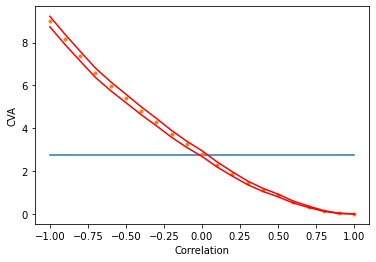

In [25]:
plt.plot(corr_tested,[uncorr_cva]*21)
plt.plot(corr_tested,cva_estimates,'.')
plt.plot(corr_tested,cva_estimates+3*np.array(cva_std),'r')
plt.plot(corr_tested,cva_estimates-3*np.array(cva_std),'r')
plt.xlabel("Correlation")
plt.ylabel("CVA")
plt.show()

# Question 9 

Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA

In [37]:
# Monte carlo estimates for the price of the option

mc_pricing = mcall_val - amount_lost

In [38]:
mc_pricing

array([46.41209163,  0.        , 13.2320014 , ..., 12.84693354,
       25.78351683,  0.        ])

In [39]:
np.mean(mc_pricing)

15.63496410618048

In [41]:
Sizes=[None]*50

In [ ]:
mc_pricing = mcall_val - amount_lost

#Plot the price of the option taking account CVA
plt.plot(Sizes,mc_pricing)
plt.xlabel("Sample sizes")
plt.ylabel("Prices")
plt.title("Option pricing for CVA")
plt.show()